In [63]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'#Times New Roma
plt.rcParams['font.size'] = 12

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV,cross_val_score,cross_validate,KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc,precision_recall_curve,accuracy_score,make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
# 使用以下分类模型
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## 一、读取数据+数据预处理

<!-- ## 一、读取数据+数据预处理 -->

### 1、甲基化数据质量控制

In [3]:
methy_CN_AD = pd.read_excel('./specified_probes_AtoC.xlsx',sheet_name="unique") #,sheet_name="unique"

In [4]:
# 统计每个标签的数量
status_counts = methy_CN_AD['status'].value_counts()
status_counts

0    209
1     35
Name: status, dtype: int64

In [5]:
cg_CN_AD=methy_CN_AD.columns[2:]
X_CN_AD_original = methy_CN_AD.iloc[:, 2:]
y_CN_AD = methy_CN_AD["status"]

# X_CN_AD = StandardScaler().fit_transform(X_CN_AD)
# X_CN_AD = pd.DataFrame(X_CN_AD, columns=cg_CN_AD)

In [154]:
# methy_CN_AD.loc[methy_CN_AD["status"]=="CN","status"]=0
# methy_CN_AD.loc[methy_CN_AD["status"]=="AD","status"]=1
# methy_CN_AD

In [187]:
# 分割数据集为训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X_CN_AD, y_CN_AD, test_size=0.3, random_state=42) #X_resampled, y_resampled

### 2、特征过滤（过滤法）

In [12]:
methy_CN_AD.columns

Index(['PTID', 'status', 'cg06950634', 'cg22832557', 'cg00030420',
       'cg13008301', 'cg14851485', 'cg00917569', 'cg08212438', 'cg14759366',
       ...
       'cg02090014', 'cg25982965', 'cg20615832', 'cg07850592', 'cg17484472',
       'cg17161718', 'cg22539279', 'cg27268486', 'cg12438547', 'cg20169823'],
      dtype='object', length=944)

#### （0）方差过滤

In [63]:
# # 计算每个特征的方差
# X_variances = X_CN_AD_original.var()

# # 计算方差的四分之一位数
# q1_variance = np.percentile(X_variances, 25)
# mean_variance = X_variances.mean()

# print("各特征方差的四分之一位数：", q1_variance)
# print("各特征方差的平均值：", mean_variance)

各特征方差的四分之一位数： 0.0017530619105598608
各特征方差的平均值： 0.005705512334410576


In [64]:
# '''
# 以所有特征方差的四分之一位数为阈值，过滤方差，942个特征剩下706个特征。
# '''
# from sklearn.feature_selection import VarianceThreshold

# var = VarianceThreshold(threshold = q1_variance) #这里让方差阀值等于n项特征的方差平均值
# var.fit(X_CN_AD_original)
# # var.variances_ #每个特征对应的方差值
# # X_rm_varq1 = var.transform(X_CN_AD_original) #返回被留下的特征列
# keep_features = X_CN_AD_original.columns[var.get_support()]  # 获取被保留特征列的标题


In [66]:
# # keep_features = keep_features.insert(0,'status')
# data_varq1 = methy_CN_AD[keep_features]
# X_varq1 = data_varq1.iloc[:,1:]
# y_varq1 = data_varq1["status"]

#### （1）Fisher Score  过滤

In [6]:
#标签只能为0和1,特征空间任意，
#X_data:n*m 的数值列表
#y_data:m*1 的数值列表
#返回每个特征的fisher score值的一个列表

def binary_fisher_score(X_data,y_data):
    if len(X_data) != len(y_data):
        print('Sample does not match label')
        exit()
    df1 = pd.DataFrame(X_data)
    df2 = pd.DataFrame(y_data, columns=['status'])
    data = pd.concat([df1, df2], axis=1)  # 合并成为一个dataframe
    
    data0 = data[y_data == 0]#对status分类，分成包含0和1的两个dataframe
    data1 = data[y_data == 1]
    n = len(y_data)#标签长度
    n1 = sum(y_data)#1类标签的个数
    n0 = n - n1#0类标签的个数
    lst = []#用于返回的列表
    features_list = list(data.columns)[:-1]
    for feature in features_list:
        # 算关于data0
        m0_feature_mean = data0[feature].mean()  # 0类标签在第m维上的均值
        # 0类在第m维上的sw
        m0_SW=sum((data0[feature] -m0_feature_mean )**2)
        # 算关于data1
        m1_feature_mean = data1[feature].mean()  # 1类标签在第m维上的均值
        # 1类在第m维上的sw
        m1_SW=sum((data1[feature] -m1_feature_mean )**2)
        # 算关于data
        m_all_feature_mean = data[feature].mean()  # 所有类标签在第m维上的均值

        m0_SB = n0 / n * (m0_feature_mean - m_all_feature_mean) ** 2
        m1_SB = n1 / n * (m1_feature_mean - m_all_feature_mean) ** 2
        #计算SB
        m_SB = m1_SB + m0_SB
        #计算SW
        m_SW = (m0_SW + m1_SW) / n
        if m_SW == 0:
            # 0/0类型也是返回nan
            m_fisher_score = np.nan
        else:
            # 计算Fisher score
            m_fisher_score = m_SB / m_SW
        #Fisher score值添加进列表
        lst.append(m_fisher_score)

    return lst

In [7]:
# 计算Fisher score分数：类内方差最小，类间方差最大  942-->706个
fisher_ret = binary_fisher_score(X_CN_AD_original.values, y_CN_AD.values)

In [8]:
summary = pd.Series(fisher_ret).describe()
print("\n信息增益汇总统计信息：\n",summary)  
'''
信息增益汇总统计信息：
 count    942.000000
mean       0.022943
std        0.007282
min        0.016724
25%        0.018308
50%        0.020537
75%        0.024850
max        0.104499
'''


信息增益汇总统计信息：
 count    942.000000
mean       0.020956
std        0.011756
min        0.000196
25%        0.011579
50%        0.020173
75%        0.028591
max        0.067211
dtype: float64


'\n信息增益汇总统计信息：\n count    942.000000\nmean       0.022943\nstd        0.007282\nmin        0.016724\n25%        0.018308\n50%        0.020537\n75%        0.024850\nmax        0.104499\n'

In [9]:
# 找出大于阈值的索引  四分之一位数
fr_indices = [i for i, value in enumerate(fisher_ret) if value > 0.011579]

# 从另一个列表中提取这些索引对应的值
fr_features = [cg_CN_AD[i] for i in fr_indices]
len(fr_features)

706

In [10]:
frfeatures = fr_features.insert(0,'status')
data_frq1 = methy_CN_AD[fr_features]
X_frq1 = data_frq1.iloc[:,1:]
y_frq1 = data_frq1["status"]

#### （2）信息增益过滤

In [11]:
# summary = features_sorted_by_info_gain.describe()
# print("\n信息增益汇总统计信息：\n",summary)

In [12]:
'''
将过滤四分位方差的特征进一步计算信息增益，降序排列后，选择特定阈值或特定个数的特征
这里设置阈值为：所有特征信息增益的四分位数。
剩下634个特征
'''
from sklearn.feature_selection import mutual_info_classif


# 计算每个特征和标签之间的信息增益
info_gain = mutual_info_classif(X_frq1, y_frq1)

# 将特征根据信息增益排序
features_sorted_by_info_gain = pd.Series(info_gain, index=X_frq1.columns).sort_values(ascending=False)

# 设定信息增益的阈值，过滤特征
ig_threshold = np.percentile(features_sorted_by_info_gain.var(),25)
ig_features = features_sorted_by_info_gain[features_sorted_by_info_gain > ig_threshold].index


# print("基于阈值过滤后的特征：\n", X_filtered_by_threshold)

# # 或者剔除指定个数的低分特征
# k = 2  # 选择信息增益最高的k个特征
# selector = SelectKBest(mutual_info_classif, k=k)
# X_selected_by_top_k = selector.fit_transform(X_varq1, y_varq1)
# selected_features_by_top_k = X_varq1.columns[selector.get_support()]

# print("选择信息增益最高的特征：\n", selected_features_by_top_k)

In [13]:
print("剩余特征数量：",len(ig_features))

剩余特征数量： 472


In [14]:
keep_features_ = ig_features.insert(0,'status')
data_igq1 = methy_CN_AD[keep_features_]
X_igq1 = data_igq1.iloc[:,1:]
y_igq1 = data_igq1["status"]

In [15]:
Counter(data_igq1.status)

Counter({0: 209, 1: 35})

### 3、基于聚类的混合采样

#### （1）对少数类（AD）的过采样

In [16]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE

#UR = 5.97 属于中等不均衡

sm = BorderlineSMOTE(
    random_state=42,
    kind="borderline-1",
    sampling_strategy={0: 209, 1: 104},#{0: 647,1:376}    {0: 209, 1: 104} 这是令IR=2
    k_neighbors=5, #确定邻居点的数量
    m_neighbors=10) #指定在合成样本生成过程中从近邻点中选择多少个样本作为参考
X_bdsmote, y_bdsmote = sm.fit_resample(X_igq1, y_igq1)
print('Resampled dataset shape %s' % Counter(y_bdsmote))
# 合并为一个新的dataframe
y_bdsmote = pd.Series(y_bdsmote,name="status")
data_bdsmote = pd.concat([X_bdsmote, y_bdsmote], axis=1)

Resampled dataset shape Counter({0: 209, 1: 104})


#### （3）对多数类的欠采样

In [17]:
from sklearn.neighbors import NearestNeighbors
from imblearn.under_sampling import TomekLinks
from collections import Counter

def find_and_remove_danger_samples(X, y, k=5):
    """
    找出多数类中的 'danger' 样本，并将其删除
    
    参数:
    - X: 特征矩阵 (DataFrame 或 2D NumPy 数组)
    - y: 标签 (Series 或 1D NumPy 数组)
    - k: KNN 的 k 值
    
    返回:
    - X_cleaned: 清理后的特征矩阵
    - y_cleaned: 清理后的标签
    """
    
    # 将 X 和 y 转换为 NumPy 数组
    X = np.array(X)
    y = np.array(y)
    
    # 识别多数类
    majority_class = max(set(y), key=list(y).count)
    
    # 初始化 KNN
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    
    danger_indices = []
    
    for idx, x in enumerate(X):
        if y[idx] == majority_class:
            # 找到最近邻居
            neighbors = neigh.kneighbors([x], return_distance=False)
            neighbor_labels = y[neighbors[0]]
            
            # 计算该样本的最近邻中少数类样本的数量
            minority_count = np.sum(neighbor_labels != majority_class)
            
            # 判断是否为 'danger' 样本
            if minority_count > k / 2:
                danger_indices.append(idx)
    
    # 删除 'danger' 样本
    X_cleaned = np.delete(X, danger_indices, axis=0)
    y_cleaned = np.delete(y, danger_indices, axis=0)
    
    return X_cleaned, y_cleaned

In [18]:
X_cleaned, y_cleaned = find_and_remove_danger_samples(X_bdsmote.values, data_bdsmote["status"], k=5)
print(f"Cleaned dataset shape: {Counter(y_cleaned)}")

Cleaned dataset shape: Counter({0: 110, 1: 104})


In [19]:
# 合并为一个新的dataframe
# new_sample = [f'Sample{i+1}' for i in range(len(X_cleaned))]  
X_bdknn = pd.DataFrame(X_cleaned,columns=X_bdsmote.columns)
y_bdknn = pd.Series(y_cleaned,name="status")
data_bdknn = pd.concat([X_bdknn, y_bdknn], axis=1)

#### (3)画出降维后的结果

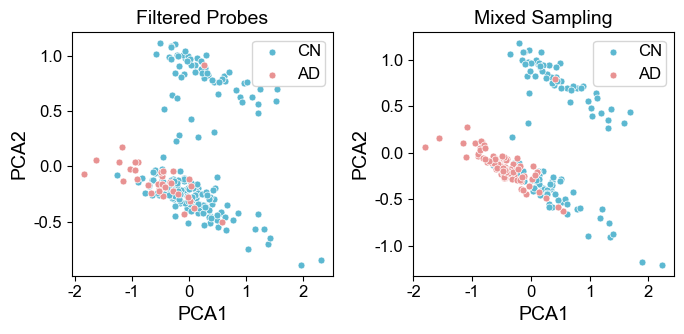

In [97]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA(n_components=2)
X_igq1_pca = pca.fit_transform(X_igq1)
X_bdsmote_pca = pca.fit_transform(X_bdsmote)
X_bdknn_pca = pca.fit_transform(X_cleaned)



# 创建一个包含左右两个子图的图形
# fig, axes = plt.subplots(1, 3, figsize=(9,3))
fig, axes = plt.subplots(1, 2, figsize=(7,3.5))


# 左图：绘制原始数据的散点图
# axes[0].scatter(X_igq1_pca[:, 0], X_igq1_pca[:, 1], c=y_igq1, cmap='viridis', alpha=0.7)
# 绘制类别 0 的点
axes[0].scatter(X_igq1_pca[y_igq1 == 0, 0], X_igq1_pca[y_igq1 == 0, 1], 
                label='CN', alpha=1, s=25,edgecolors='w', linewidths=0.5, color='#5cb8d1' )#edgecolors='w', cmap='viridis'
# 绘制类别 1 的点
axes[0].scatter(X_igq1_pca[y_igq1 == 1, 0], X_igq1_pca[y_igq1 == 1, 1], 
                label='AD', alpha=1, s=25,edgecolors='w', linewidths=0.5, color='#e89292' )
axes[0].set_xlabel('PCA1', fontdict={'family':'Arial', 'size':14})
axes[0].set_ylabel('PCA2', fontdict={'family':'Arial', 'size':14})
axes[0].set_title('Filtered Probes', fontdict={'family':'Arial', 'size':14})
# 添加图例
axes[0].legend(handletextpad=0.5, prop={'family': 'Arial'}, fontsize=14, borderpad=0.2,loc='upper right')



# # 中图：绘制过采样后数据的散点图
# # 绘制类别 0 的点
# axes[1].scatter(X_bdsmote_pca[y_bdsmote == 0, 0], X_bdsmote_pca[y_bdsmote == 0, 1], 
#                 label='CN', alpha=0.6, edgecolors='w', s=50, cmap='viridis')
# # 绘制类别 1 的点
# axes[1].scatter(X_bdsmote_pca[y_bdsmote == 1, 0], X_bdsmote_pca[y_bdsmote == 1, 1], 
#                 label='AD', alpha=0.6, edgecolors='w', s=50, cmap='viridis')

# axes[1].set_xlabel('Component 1', fontdict={'family':'Arial', 'size':12})
# axes[1].set_ylabel('Component 2', fontdict={'family':'Arial', 'size':12})
# axes[1].set_title('Borderline SMOTE', fontdict={'family':'Arial', 'size':13})
# # 添加图例
# axes[1].legend(handletextpad=0.5, prop={'family': 'Arial'}, fontsize=12, borderpad=0.2)



# 右图：绘制欠采样后数据的散点图
# 绘制类别 0 的点
axes[1].scatter(X_bdknn_pca[y_cleaned == 0, 0], -X_bdknn_pca[y_cleaned == 0, 1], 
                label='CN', alpha=1, s=25,edgecolors='w', linewidths=0.5, color='#5cb8d1' )
# 绘制类别 1 的点
axes[1].scatter(X_bdknn_pca[y_cleaned == 1, 0], -X_bdknn_pca[y_cleaned == 1, 1], 
                label='AD', alpha=1, s=25,edgecolors='w', linewidths=0.5, color='#e89292')# edgecolors='w',
axes[1].set_xlabel('PCA1', fontdict={'family':'Arial', 'size':14})
axes[1].set_ylabel('PCA2', fontdict={'family':'Arial', 'size':14})
axes[1].set_title('Mixed Sampling', fontdict={'family':'Arial', 'size':14})
# 添加图例
axes[1].legend(handletextpad=0.5, prop={'family': 'Arial'}, fontsize=14, borderpad=0.2,title='')

# fig.suptitle('CN vs. AD', fontsize=14, y=0.95,x=0.6)


# 调整子图间距
plt.tight_layout()

# 显示图形
plt.show()


In [259]:
# # 分割数据集为训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X_bdknn, y_bdknn, test_size=0.3, random_state=42) #X_resampled, y_resampled
# # ig_features

## 二、特征挑选——随机森林

### 1、基于Embedded Methods
将特征选择嵌入到模型训练过程中，即在模型的训练过程中同时完成特征选择和模型训练。

In [53]:
#计算 G-mean 分数
def g_mean_score(y_true, y_pred):
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # 计算真正率
    recall_pos = tp / (tp + fn)  # 对于正类
    recall_neg = tn / (tn + fp)  # 对于负类
    # 计算 G-mean
    g_mean = np.sqrt(recall_pos * recall_neg)
    
    return g_mean

In [54]:
# 训练随机森林模型

# # 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_bdknn, y_bdknn, test_size=0.3, random_state=42) 

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_predict_rf = model_rf.predict(X_test)
y_score_rf = model_rf.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_test,y_score_rf, multi_class='ovr')
accuracy_rf = accuracy_score(y_test, y_predict_rf)
precision_rf = precision_score(y_test, y_predict_rf, average='weighted')
recall_rf = recall_score(y_test, y_predict_rf, average='weighted')
f1_rf= f1_score(y_test, y_predict_rf, average='weighted')

print('auc_score = ', auc_rf)
print('accuracy = ', accuracy_rf)
print('prediction = ', precision_rf)
print('recall = ', recall_rf)
print('f1_score = ', f1_rf)

auc_score =  0.9821428571428571
accuracy =  0.9538461538461539
prediction =  0.954479811376363
recall =  0.9538461538461539
f1_score =  0.9539348899118185


In [55]:
# 选择特征重要性得分排名前50的特征
top15_features_rf = ig_features[np.argsort(model_rf.feature_importances_)[::-1][:50]]
# print("Selected features:", top30_features_rf)

## 三、SVM分类

In [56]:
# 初始化 SVM 模型
est_svm = SVC(kernel='rbf', probability=True)
# 初始化 5 折交叉验证
kf = StratifiedKFold(n_splits=10)

# 交叉验证
def cal_scores(X,y):
    # 用于保存每个折叠的结果
    auc_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    g_means = []

    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 训练模型
        est_svm.fit(X_train, y_train)

        # 预测
        y_predict_svm = est_svm.predict(X_test)
        y_score_svm = est_svm.predict_proba(X_test)[:, 1]

        # 计算各项指标
        auc_svm = roc_auc_score(y_test, y_score_svm)
        accuracy_svm = accuracy_score(y_test, y_predict_svm)
        precision_svm = precision_score(y_test, y_predict_svm)
        recall_svm = recall_score(y_test, y_predict_svm)
        f1_svm = f1_score(y_test, y_predict_svm)
        gmean_svm = g_mean_score(y_test, y_predict_svm)

        # 保存结果
        auc_scores.append(auc_svm)
        accuracy_scores.append(accuracy_svm)
        precision_scores.append(precision_svm)
        recall_scores.append(recall_svm)
        f1_scores.append(f1_svm)
        g_means.append(gmean_svm)

    # 计算平均值
    mean_auc = np.mean(auc_scores)
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_g = np.mean(g_means)
    
    return mean_accuracy,mean_precision,mean_f1,mean_g

In [57]:
# 带入使用
X_rf = data_bdknn.iloc[:,:-1][top15_features_rf]
y = data_bdknn['status']

# 存储结果的列表 rf
num_features_rf = []
Accuracy_scores_rf = []
Precision_scores_rf = []
F1_scores_rf = []
Gmean_scores_rf = []

# 遍历特征列表，进行交叉验证
for i in range(1, len(top15_features_rf) + 1):
    # 选择前i个特征
    selected_features = top15_features_rf[:i]
    X_subset = X_rf[selected_features]  # 提取子集特征
    
    # 进行五折交叉验证 
    mean_accuracy,mean_precision,mean_f1,mean_g = cal_scores(X_subset,y)
    
    num_features_rf.append(i)
    Accuracy_scores_rf.append(mean_accuracy)
    Precision_scores_rf.append(mean_precision)
    F1_scores_rf.append(mean_f1)
    Gmean_scores_rf.append(mean_g)

In [98]:
plt.rcParams['font.size'] = 16

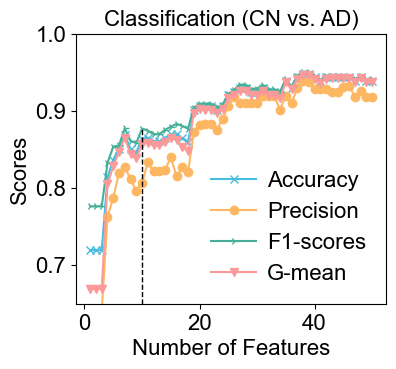

In [100]:
# 绘制ACC值随特征数量变化的曲线
plt.figure(figsize=(4,3.5))
           
plt.plot(num_features_rf, Accuracy_scores_rf, marker='x', linestyle='-',label="Accuracy",color='#46BDDD')
plt.plot(num_features_rf, Precision_scores_rf, marker='o', linestyle='-',label="Precision",color='#FDB762')
plt.plot(num_features_rf, F1_scores_rf, marker='4', linestyle='-',label="F1-scores",color='#48B098')
plt.plot(num_features_rf, Gmean_scores_rf, marker='v', linestyle='-',label="G-mean",color='#FB9A99')

plt.plot([10, 10], [0.65, F1_scores_rf[9]], color='black', linestyle='--', linewidth=1)
# plt.xticks(num_features_rf) 

plt.xlabel('Number of Features',fontdict={'family':'Arial','size':16}) #Times New Roman
plt.ylabel('Scores',fontdict={'family':'Arial', 'size':16}) 
plt.title('Classification (CN vs. AD)',fontdict={'family':'Arial', 'size':16})
plt.ylim(0.65,1)
plt.legend(handletextpad=0.5, prop={'family': 'Arial'}, framealpha=0,loc='lower right')
# plt.grid(True)

# 仅启用垂直网格线
# plt.grid(True, axis='x', which='both', color='gray')

# 为每个数据点绘制垂直网格线

    
# for x, y in zip(num_features_rf, F1_scores_rf):
#     plt.plot([x, x], [0.62, y], color='gray', linestyle='--', linewidth=0.5)


plt.show()

In [30]:
# 特征数量取10
X_top10 = data_bdknn.iloc[:,:-1][top15_features_rf].iloc[:,:10]
y = data_bdknn["status"]
mean_accuracy,mean_precision,mean_f1,mean_g = cal_scores(X_top10,y)
# #  计算和输出混淆矩阵
# conf_matrix = confusion_matrix(y_test, y_predict_svm)
# print('Confusion Matrix:')
# print(conf_matrix)
# 输出结果
print(f'Mean Accuracy = {mean_accuracy:.4f}')
print(f'Mean Precision = {mean_precision:.4f}')
print(f'Mean F1 Score = {mean_f1:.4f}')
print(f'Mean G-mean = {mean_g:.4f}')

Mean Accuracy = 0.8645
Mean Precision = 0.8063
Mean F1 Score = 0.8774
Mean G-mean = 0.8575


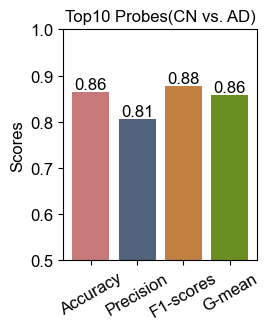

In [88]:
import matplotlib.pyplot as plt

# Data
metrics = ['Accuracy', 'Precision', 'F1-scores', 'G-mean']
values = [0.8645, 0.8063, 0.8774, 0.8575]
colors = ['#c77979', '#50627c', '#bf8040', '#6b8e23']  # Warm muted colors

# Create the bar chart
plt.figure(figsize=(2.5, 3))
bars = plt.bar(metrics, values, color=colors)

plt.xticks(rotation=30)

# Add text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('',fontsize=12)
plt.ylabel('Scores',fontsize=12)
plt.title('Top10 Probes(CN vs. AD)',fontsize=12)
plt.ylim(0.5, 1)  # Adjust y-axis to better fit the range of the data

# Adding the text labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


In [31]:
data_bdknn.iloc[:,:-1][top15_features_rf].iloc[:,:10].columns

#['cg26896946', 'cg06536614', 'cg07972135', 'cg27657429', 'cg18678645',
#        'cg24199400', 'cg04481923', 'cg11921736', 'cg05652809', 'cg01755562']

Index(['cg26896946', 'cg06536614', 'cg07972135', 'cg27657429', 'cg18678645',
       'cg24199400', 'cg04481923', 'cg11921736', 'cg05652809', 'cg01755562'],
      dtype='object')

In [5]:
top10_features = ['PTID','status','cg26896946', 'cg06536614', 'cg07972135', 'cg27657429', 'cg18678645',
                   'cg24199400', 'cg04481923', 'cg11921736', 'cg05652809', 'cg01755562']
top10_df = methy_CN_AD[top10_features]
top10_df.to_excel("./top10_CN_AD.xlsx",index=False)